In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hist_image(img, ax: plt.Axes, title=''):
  ax.hist(img.ravel(), bins=256, range=(0, 256), fc='k', ec='k')

def laplacian_variance(img):
  # The bigger the variance, the more in-focus the image is
  return np.round(cv2.Laplacian(img, cv2.CV_64F).var())

def get_metrics(img):
  return f"blur: {laplacian_variance(img)}, mean: {np.mean(img).round()}, std: {np.std(img).round()}"


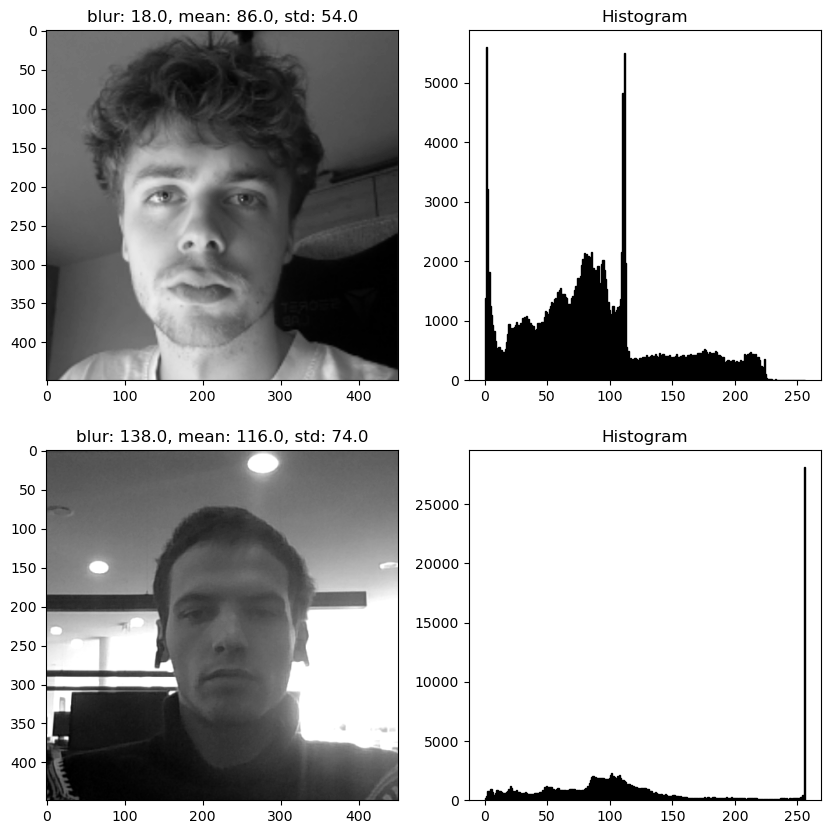

In [82]:
im = cv2.imread("../assets/model.png", 0) # read as gray scale
im2 = cv2.imread("../assets/model2.png", 0) # read as gray scale

blurred_im = cv2.GaussianBlur(im, (17, 17), 0)

_, axs = plt.subplots(2, 2, figsize=(10, 10))

print()
axs[0,0].imshow(im, cmap='gray')
axs[0,0].set_title(get_metrics(im))
hist_image(im, axs[0,1])
axs[0,1].set_title("Histogram")

axs[1,0].imshow(im2, cmap='gray')
axs[1,0].set_title(get_metrics(im2))
hist_image(im2, axs[1,1])
axs[1,1].set_title("Histogram")

plt.show()

## Augmenting data

Control light with gamma correction

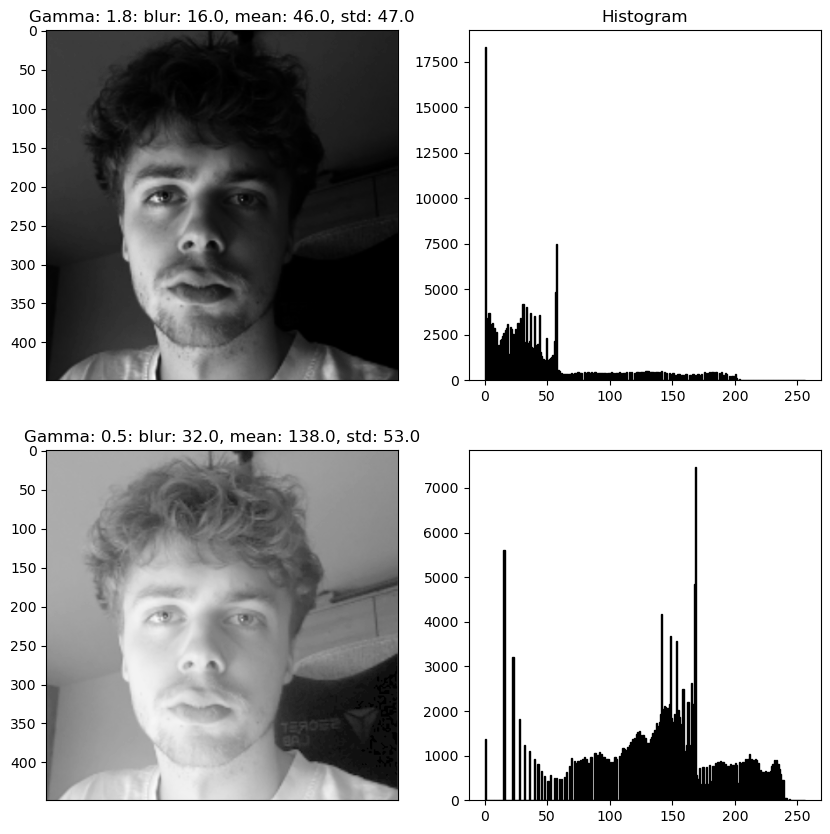

In [100]:
gamma_factor = 1.8
img_dark_gamma = 255 * (im / 255) ** gamma_factor
_, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(img_dark_gamma, cmap='gray')
axs[0,0].set_title(f"Gamma: {gamma_factor}: "+get_metrics(img_dark_gamma))
axs[0,0].set_xticks([])
hist_image(img_dark_gamma, axs[0,1])
axs[0,1].set_title("Histogram")

gamma_factor = 0.5
img_light_gamma = 255 * (im / 255) ** gamma_factor

axs[1,0].imshow(img_light_gamma, cmap='gray')
axs[1,0].set_title(f"Gamma: {gamma_factor}: "+get_metrics(img_light_gamma))
axs[1,0].set_xticks([])
hist_image(img_light_gamma, axs[1,1])

Control blur with GaussianBlur or AveragePooling

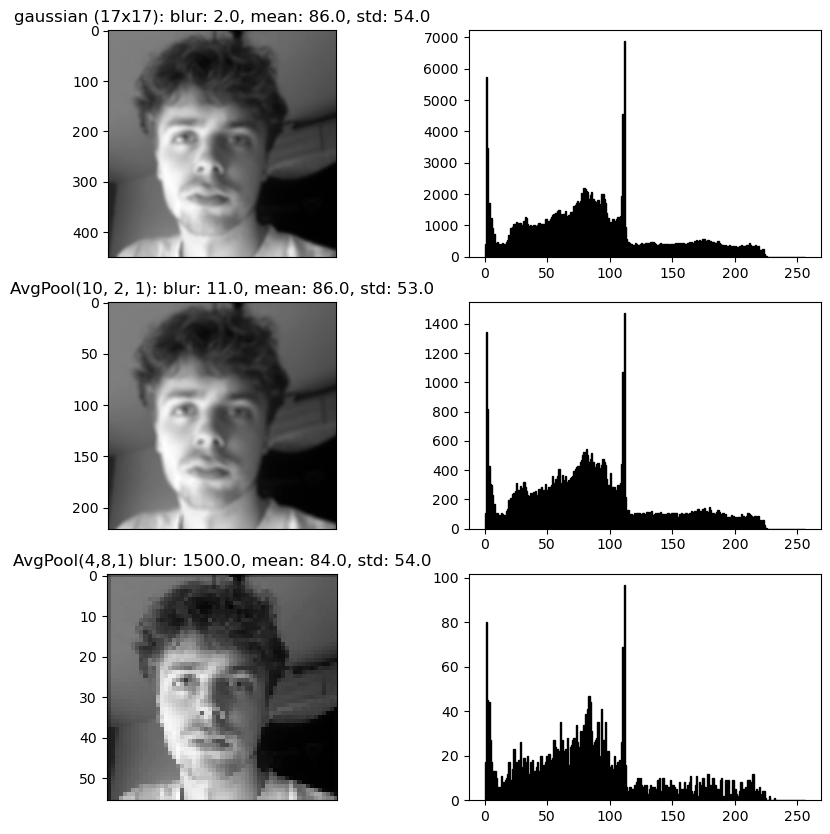

In [84]:
blurred_im = cv2.GaussianBlur(im, (17, 17), 0)
import torch
pooling1 = torch.nn.AvgPool2d(10, stride=2, padding=1)
pooled1_im = np.rint(pooling1(torch.tensor(im/255).float().unsqueeze(0).unsqueeze(0)).squeeze().numpy() * 255).astype(np.uint8)

pooling2 = torch.nn.AvgPool2d(4, stride=8, padding=1)
pooled2_im = np.rint(pooling2(torch.tensor(im/255).float().unsqueeze(0).unsqueeze(0)).squeeze().numpy() * 255).astype(np.uint8)

_, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0,0].imshow(blurred_im, cmap='gray')
axs[0,0].set_title("gaussian (17x17): "+get_metrics(blurred_im))
axs[0,0].set_xticks([])
hist_image(blurred_im, axs[0,1])

axs[1,0].imshow(pooled1_im, cmap='gray')
axs[1,0].set_title("AvgPool(10, 2, 1): "+get_metrics(pooled1_im))
axs[1,0].set_xticks([])
hist_image(pooled1_im, axs[1,1])

axs[2,0].imshow(pooled2_im, cmap='gray')
axs[2,0].set_title("AvgPool(4,8,1) "+get_metrics(pooled2_im))
axs[2,0].set_xticks([])
hist_image(pooled2_im, axs[2,1])


Text(0.5, 1.0, 'blur: 58.0, mean: 162.0, std: 60.0')

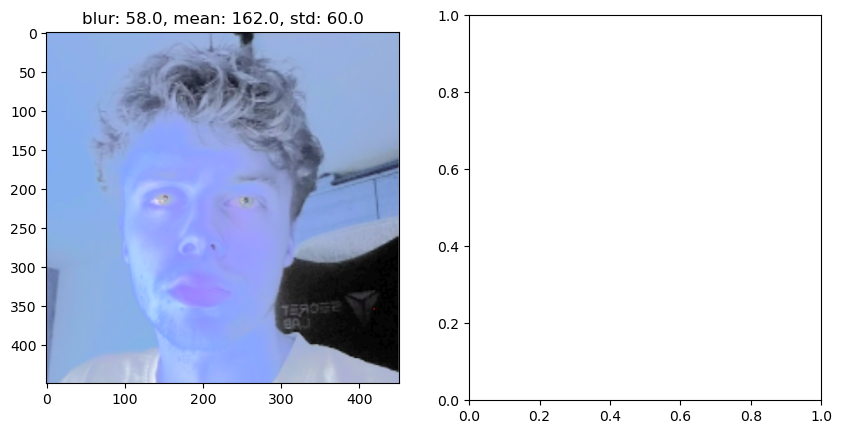

In [117]:
def correction(
        img,
        shadow_amount_percent, shadow_tone_percent, shadow_radius,
        highlight_amount_percent, highlight_tone_percent, highlight_radius,
        color_percent
):
    """
    Image Shadow / Highlight Correction. The same function as it in Photoshop / GIMP
    :param img: input RGB image numpy array of shape (height, width, 3)
    :param shadow_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param shadow_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param shadow_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param highlight_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param highlight_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param highlight_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param color_percent [-1.0 ~ 1.0]:
    :return:
    """
    shadow_tone = shadow_tone_percent * 255
    highlight_tone = 255 - highlight_tone_percent * 255

    shadow_gain = 1 + shadow_amount_percent * 6
    highlight_gain = 1 + highlight_amount_percent * 6

    # extract RGB channel
    height, width = img.shape[:2]
    img = img.astype(np.float32)
    img_R, img_G, img_B = img[..., 2].reshape(-1), img[..., 1].reshape(-1), img[..., 0].reshape(-1)

    # The entire correction process is carried out in YUV space,
    # adjust highlights/shadows in Y space, and adjust colors in UV space
    # convert to Y channel (grey intensity) and UV channel (color)
    img_Y = .3 * img_R + .59 * img_G + .11 * img_B
    img_U = -img_R * .168736 - img_G * .331264 + img_B * .5
    img_V = img_R * .5 - img_G * .418688 - img_B * .081312

    # extract shadow / highlight
    shadow_map = 255 - img_Y * 255 / shadow_tone
    shadow_map[np.where(img_Y >= shadow_tone)] = 0
    highlight_map = 255 - (255 - img_Y) * 255 / (255 - highlight_tone)
    highlight_map[np.where(img_Y <= highlight_tone)] = 0

    # // Gaussian blur on tone map, for smoother transition
    if shadow_amount_percent * shadow_radius > 0:
        # shadow_map = cv2.GaussianBlur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius), sigmaX=0).reshape(-1)
        shadow_map = cv2.blur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius)).reshape(-1)

    if highlight_amount_percent * highlight_radius > 0:
        # highlight_map = cv2.GaussianBlur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius), sigmaX=0).reshape(-1)
        highlight_map = cv2.blur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius)).reshape(-1)

    # Tone LUT
    t = np.arange(256)
    LUT_shadow = (1 - np.power(1 - t * (1 / 255), shadow_gain)) * 255
    LUT_shadow = np.maximum(0, np.minimum(255, np.int_(LUT_shadow + .5)))
    LUT_highlight = np.power(t * (1 / 255), highlight_gain) * 255
    LUT_highlight = np.maximum(0, np.minimum(255, np.int_(LUT_highlight + .5)))

    # adjust tone
    shadow_map = shadow_map * (1 / 255)
    highlight_map = highlight_map * (1 / 255)

    iH = (1 - shadow_map) * img_Y + shadow_map * LUT_shadow[np.int_(img_Y)]
    iH = (1 - highlight_map) * iH + highlight_map * LUT_highlight[np.int_(iH)]
    img_Y = iH

    # adjust color
    if color_percent != 0:
        # color LUT
        if color_percent > 0:
            LUT = (1 - np.sqrt(np.arange(32768)) * (1 / 128)) * color_percent + 1
        else:
            LUT = np.sqrt(np.arange(32768)) * (1 / 128) * color_percent + 1

        # adjust color saturation adaptively according to highlights/shadows
        color_gain = LUT[np.int_(img_U ** 2 + img_V ** 2 + .5)]
        w = 1 - np.minimum(2 - (shadow_map + highlight_map), 1)
        img_U = w * img_U + (1 - w) * img_U * color_gain
        img_V = w * img_V + (1 - w) * img_V * color_gain

    # re convert to RGB channel
    output_R = np.int_(img_Y + 1.402 * img_V + .5)
    output_G = np.int_(img_Y - .34414 * img_U - .71414 * img_V + .5)
    output_B = np.int_(img_Y + 1.772 * img_U + .5)

    output = np.row_stack([output_B, output_G, output_R]).T.reshape(height, width, 3)
    output = np.minimum(output, 255).astype(np.uint8)
    return output

im = cv2.imread("../assets/model.png", cv2.COLOR_RGB2BGR) # read as RGB
# im = im / 255
corrected = correction(im, 1, 1, 1, 0, 1, 1, 1)
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(corrected, cmap='gray')
axs[0].set_title(get_metrics(corrected))
